In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
import re
import numpy as np
import seaborn as sns
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from skimage import io
from patchify import patchify, unpatchify
%matplotlib inline

import collections

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [2]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Creating the heatmap
    plt.figure(figsize=(8,5))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues', vmin = 0)
    plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

In [3]:
def balance_dataset(X, y):
    # Separate the data into classes
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]

    # Sample an equal number of samples from each class
    num_samples_per_class = min(len(class_0_indices), len(class_1_indices))

    # Randomly sample indices for each class
    sampled_indices_class_0 = np.random.choice(class_0_indices, num_samples_per_class, replace=False)
    sampled_indices_class_1 = np.random.choice(class_1_indices, num_samples_per_class, replace=False)

    # Combine the sampled indices
    sampled_indices = np.concatenate([sampled_indices_class_0, sampled_indices_class_1])

    # Use the sampled indices to create the balanced training set
    X_balanced = X[sampled_indices]
    y_balanced = y[sampled_indices]

    # Check the balance in y_train_balanced
    print(np.bincount(y_balanced))

    return(X_balanced, y_balanced)

In [4]:
fog_aware_pivot = pd.read_csv('fog_aware_stats_horizontal_3_patches_pivot.csv')
fog_aware_pivot['Label_train'] = 1*(fog_aware_pivot['Label']=='foggy')
fog_aware_pivot

,photo,Label,site,hour,mscn_var_0,mscn_var_1,mscn_var_2,vertical_var_0,vertical_var_1,vertical_var_2,...,dark_channel_prior_0,dark_channel_prior_1,dark_channel_prior_2,color_sat_0,color_sat_1,color_sat_2,CF_0,CF_1,CF_2,Label_train
0,2022_07-04.0000_agatebeachor.jpg,not_foggy,agatebeachor,0,0.220805,0.285012,0.099900,0.065638,0.106588,0.034401,...,28.0,6.0,14.0,0.000000,0.000000,0.000000,85.593872,51.769043,10.103722,0
1,2022_07-04.0000_otterrockor.jpg,not_foggy,otterrockor,0,0.725298,0.720047,0.691137,0.493167,0.477681,0.461369,...,2.0,4.0,0.0,0.244513,0.152914,0.160079,90.752732,158.670973,166.963307,0
2,2022_07-04.0700_agatebeachor.jpg,not_foggy,agatebeachor,7,0.096299,0.131353,0.173731,0.015461,0.041110,0.050096,...,64.0,24.0,37.0,0.000000,0.000000,0.000000,35.000917,18.467704,9.174465,0
3,2022_07-04.0730_agatebeachor.jpg,not_foggy,agatebeachor,7,0.101561,0.205493,0.325304,0.016175,0.091502,0.142794,...,95.0,13.0,20.0,0.063917,0.072188,0.164992,105.608782,106.996344,147.341268,0
4,2022_07-04.0730_otterrockor.jpg,not_foggy,otterrockor,7,0.251876,0.576411,0.588961,0.082378,0.292454,0.396829,...,7.0,0.0,0.0,0.099916,0.042100,0.124894,110.066753,189.517876,183.865692,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,2023_09-30.1900_agatebeachor.jpg,not_foggy,agatebeachor,19,0.176457,0.743293,0.523022,0.083535,0.457137,0.265502,...,70.0,0.0,0.0,0.041942,0.085205,0.077075,182.964334,69.402653,135.332656,0
7992,2023_09-30.1930_cannonbeach.jpg,not_foggy,cannonbeach,19,0.164592,0.585149,0.640644,0.042335,0.314184,0.390172,...,0.0,0.0,0.0,0.039959,0.058892,0.092489,137.364165,106.650678,174.568957,0
7993,2023_09-30.2000_otterrockor.jpg,not_foggy,otterrockor,20,0.282921,0.442290,0.345411,0.136875,0.235093,0.183542,...,22.0,3.0,0.0,0.125098,0.145597,0.143351,176.593142,127.302494,142.248589,0
7994,2023_09-30.2030_otterrockor.jpg,not_foggy,otterrockor,20,0.193967,0.582705,0.378667,0.059283,0.307785,0.207709,...,26.0,0.0,0.0,0.137039,0.243238,0.247271,175.215470,145.617058,152.212567,0


In [5]:
fog_aware_pivot[['Label_train', 'Label']].value_counts()

Label_train  Label    
0            not_foggy    6374
1            foggy        1622
dtype: int64

In [6]:
fog_aware_pivot
np.array(fog_aware_pivot.columns[fog_aware_pivot.columns.str.contains(r'_1|Label$')])

array(['Label', 'mscn_var_1', 'vertical_var_1', 'sharpness_1',
       'coef_or_var_sharpness_1', 'rms_contrast_1', 'entropy_1',
       'dark_channel_prior_1', 'color_sat_1', 'CF_1'], dtype=object)

In [7]:
site = 'agatebeachor'
####create summary stat datasets
summary_stats = pd.DataFrame(columns = ['site',
"Accuracy",
"Precision",
"Recall",
"F1 Score",
"AUC"
])

precision_recall = pd.DataFrame(columns = ['site','precision_array', 'recall_array' ])
roc = pd.DataFrame(columns = ['site','fpr', 'tpr'])
y_info = pd.DataFrame(columns = ['site','y_test','y_test_pred', 'y_scores'])

###define columns to keep in analysis
to_keep_3_patches = ['mscn_var_1',
'vertical_var_1',
'sharpness_1',
'coef_or_var_sharpness_1',
'rms_contrast_1']

site = 'all_sites'
X = np.array(fog_aware_pivot[to_keep_3_patches])

y = fog_aware_pivot['Label_train']

####create a 50/50 dataset of foggy not foggy
X_balanced, y_balanced = balance_dataset(X, y)


###scale the data to 0, 1
scaler = preprocessing.StandardScaler().fit(X_balanced)
X_scaled = scaler.transform(X_balanced)

####train test split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.25, random_state=42, stratify = y_balanced)


[1622 1622]


In [8]:
##### support vector machine
from sklearn import svm
threshold = 0.5

#SVM using RBF kernel
regr = svm.SVR(kernel='rbf')
regr.fit(X_train, y_train)

y_train_pred = regr.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy for SVM with rbf kernel: %.2f' % train_accuracy)

y_test_pred = regr.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with rbf kernel: %.2f' % test_accuracy)


Train accuracy for SVM with rbf kernel: 0.87
Test accuracy for SVM with rbf kernel: 0.85


In [9]:
accuracy = accuracy_score(y_test, y_test_pred_binary)
precision = precision_score(y_test, y_test_pred_binary)
recall = recall_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
roc_auc = roc_auc_score(y_test, regr.predict(X_test))

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.8532675709001233
Precision: 0.8539603960396039
Recall: 0.8518518518518519
F1 Score: 0.8529048207663783
AUC-ROC Score: 0.9313811348294108


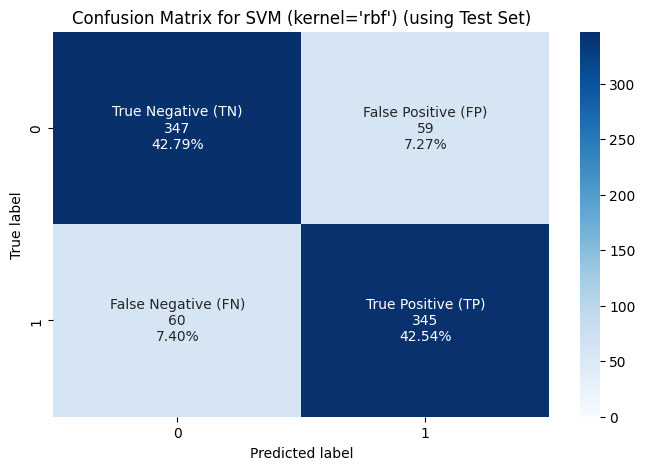

In [10]:
plot_confusion_matrix(y_test, y_test_pred_binary, "SVM (kernel='rbf')")

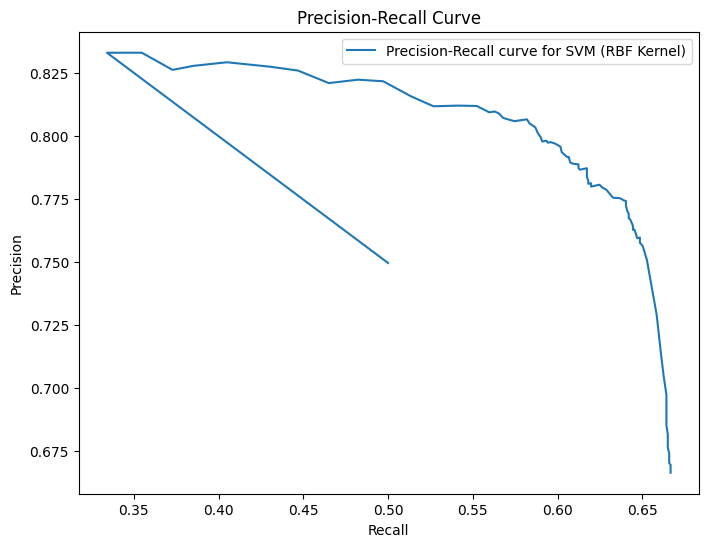

In [11]:
y_scores = regr.predict(X_test)

# Generate a range of thresholds from the minimum to the maximum predicted scores
thresholds = np.linspace(min(y_scores), max(y_scores), 100)

# Initialize lists to store precision and recall values
precisions = []
recalls = []

for t in thresholds:
  # Convert continuous predictions to binary predictions based on the current threshold
  y_pred_binary = (y_scores > t).astype(int)

  # Calculate precision and recall
  precision, recall, _ = precision_recall_curve(y_test, y_pred_binary)

  # Store the average precision and recall for the current threshold
  precisions.append(np.mean(precision))
  recalls.append(np.mean(recall))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve for SVM (RBF Kernel)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

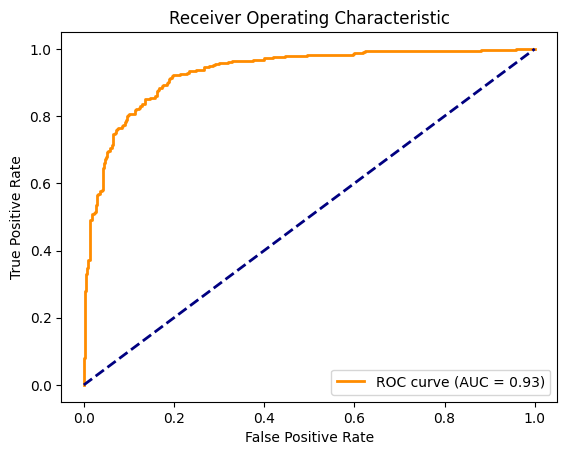

In [12]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, regr.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
####loop through sites
for site in fog_aware_pivot.site.unique():

    print(site)
    fog_aware_site = fog_aware_pivot.loc[fog_aware_pivot['site'] == site].reset_index()

    X = np.array(fog_aware_site[to_keep_3_patches])

    y = fog_aware_site['Label_train']

    ####create a 50/50 dataset of foggy not foggy
    X_balanced, y_balanced = balance_dataset(X, y)

    ###scale the data to 0, 1
    scaler = preprocessing.StandardScaler().fit(X_balanced)
    X_scaled = scaler.transform(X_balanced)

    ####train test split
    X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_balanced, test_size=0.25, random_state=42, stratify = y_balanced)
    threshold = 0.5

    #SVM using RBF kernel
    regr = svm.SVR(kernel='rbf')
    regr.fit(X_train, y_train)

    y_train_pred = regr.predict(X_train)
    y_train_pred_binary = (y_train_pred > threshold).astype(int)


    y_test_pred = regr.predict(X_test)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)

    y_scores = regr.predict(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred_binary)
    precision = precision_score(y_test, y_test_pred_binary)
    recall = recall_score(y_test, y_test_pred_binary)
    f1 = f1_score(y_test, y_test_pred_binary)
    roc_auc = roc_auc_score(y_test, y_scores)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC-ROC Score:", roc_auc)

    # Calculate precision and recall for various thresholds
    precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_scores)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    summary_stats = pd.concat([summary_stats, pd.DataFrame({'site':[site],
                    "Accuracy":[accuracy],
                    "Precision":[precision],
                    "Recall":[recall],
                    "F1 Score":[f1],
                    "AUC":[roc_auc]})], axis = 0)

    #### precision recall
    precision_recall = pd.concat([precision_recall,pd.DataFrame({'site':site,'precision_array':precision_array, 'recall_array':recall_array })],axis=0)
    ###roc chart
    roc = pd.concat([roc,pd.DataFrame({'site':site,'fpr':fpr, 'tpr':tpr})],axis=0)
    ##prediction info
    y_info = pd.concat([y_info,pd.DataFrame({'site':site,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})],axis=0)

agatebeachor
[335 335]
Accuracy: 0.8571428571428571
Precision: 0.875
Recall: 0.8333333333333334
F1 Score: 0.8536585365853658
AUC-ROC Score: 0.9359410430839001
otterrockor
[217 217]
Accuracy: 0.8256880733944955
Precision: 0.8301886792452831
Recall: 0.8148148148148148
F1 Score: 0.8224299065420562
AUC-ROC Score: 0.8851851851851852
beverlyor
[137 137]
Accuracy: 0.9130434782608695
Precision: 0.8888888888888888
Recall: 0.9411764705882353
F1 Score: 0.9142857142857143
AUC-ROC Score: 0.9815126050420168
pacificcityor
[209 209]
Accuracy: 0.9333333333333333
Precision: 0.9411764705882353
Recall: 0.9230769230769231
F1 Score: 0.9320388349514563
AUC-ROC Score: 0.945210449927431
lincolncityor
[494 494]
Accuracy: 0.7773279352226721
Precision: 0.788135593220339
Recall: 0.7560975609756098
F1 Score: 0.7717842323651453
AUC-ROC Score: 0.8779832153160241
cannonbeach
[230 230]
Accuracy: 0.8956521739130435
Precision: 0.8813559322033898
Recall: 0.9122807017543859
F1 Score: 0.8965517241379309
AUC-ROC Score: 0.970

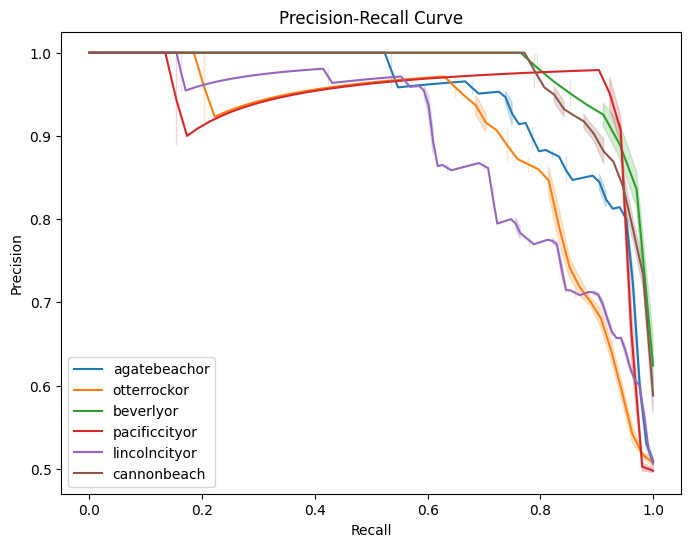

In [14]:
precision_recall = precision_recall.reset_index()
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='Precision-Recall curve')
sns.lineplot(x='recall_array', y='precision_array', hue='site', data =precision_recall )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

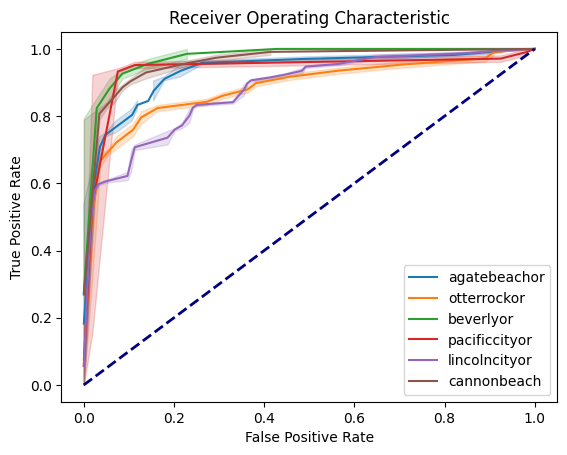

In [15]:
roc = roc.reset_index()
plt.figure()
sns.lineplot(x='fpr', y='tpr', hue='site', data =roc )
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()